Simple Linear Regression is a useful approach for predicting a response on the basis of a single predictor variable. However, in practice we often have more than one prediction. For example. in the advertising data, we have examined the relationship between sales and TV advertising. We also have data for the amount of momney spent advertising on the radio and in newspapers, and we may want to know whether either of these two media is associated with sales. How can we extend our analysis of the advertising data in order to accommodate these two additional predictors? One option is to run three separate simple linear regression, each of which uses a different advertising medium as a predictor. The approach of fitting a separate simple linear regression model for each predictor is not entirely satisfactory. 
- First of all, it is unclear how to make a single prediction of sales given the three advertising media budgets, since each of the budgets is associated with a separate regression equation. 
- Second, each of the three regression equations ignores the other two media in forming estimates for the regression coefficients. 

## Background

- Suppose that we are statistical consultants hired by a client to investigate the association between advertising and sales of a particular product.
- We are provided the dataset consists of the **sales** of one particular product in 200 diferent markets, along with advertising budgets for the product in each of those markets for three diferent media: **TV**, **Radio**, and **newspaper**.
- Client has **full control** of advertising expenses in each of the three media.
- If we determine that there is an association between advertising and alses, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales.
- **OBJECTIVE**: Our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

In [39]:
import sys
import os

# Add project root to sys.path (one level up from "notebooks/")
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from spend_sale_lib.feature_selection import forward_selection, backward_selection

## Load Dataset

- '**TV**': TV Advertising Spends, and unit is in thousands of dollars.
- '**Radio**': Radio Advertising Spends, and unit is in thousand of dollars.
- '**Newspaper**':Newspaper Advertising Spends, and unit is in thousand of dollars.
- '**Sales**':The quantities of product sale at corresponding budget of three advertising approaches, and unit is in thousand of dollars(Notice is not dollars).

In [2]:
df = pd.read_csv('../data/Advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


## Data Visualization

| Variable     | Range       | Shape                                           | Key Stats                     |
|--------------|-------------|-------------------------------------------------|-------------------------------|
| **TV**       | 0.7 – 296.4 | Fairly spread across bins; roughly uniform-ish  | mean ≈ 147, median ≈ 150      |
| **Radio**    | 0.0 – 49.6  | Slight right skew; more values at lower budgets | mean ≈ 23.3, median ≈ 22.9    |
| **Newspaper**| 0.3 – 114.0 | Right-skewed (long tail toward high spends)     | mean ≈ 30.6, median ≈ 25.8    |
| **Sales**    | 1.6 – 27.0  | Approximately bell-shaped; mild right skew      | mean ≈ 14.0, median ≈ 12.9    |

- **Spread**: TV budgets are the widest (0–300), Newspaper next, Radio tightest.  
- **Skewness**:  
  - Newspaper spend has a few potential high outliers pulling the right tail.  
  - Sales is roughly normal, with a slight tail toward higher values.

---

**Bivariate Relationships (off-diagonal scatterplots)**

1. **Sales vs TV**  
   - Strong positive linear trend: as TV ad spend increases, sales tend to rise almost linearly.  
   - ⇒ TV is a very powerful predictor of Sales.

2. **Sales vs Radio**  
   - Moderate positive trend: higher Radio budgets generally correspond to higher sales, but with more scatter.  
   - ⇒ Radio adds lift, but with more noise.

3. **Sales vs Newspaper**  
   - Weak/no clear trend: the cloud is diffuse, implying Newspaper spend is a poor standalone predictor.

4. **Inter-channel correlations**  
   - TV vs Radio, TV vs Newspaper, Radio vs Newspaper all look fairly uncorrelated—good for multicollinearity.

---

- **Prioritize TV**: clean, steep slope vs. Sales ⇒ biggest “bang for the buck.”  

- **Secondary for Radio**: some incremental lift, but noisier.  

- **Reconsider Newspaper**: minimal marginal benefit; consider reallocating budget.  

- **Modeling**: a multiple linear regression (`Sales ~ TV + Radio + Newspaper`) will likely show TV as the only highly significant coefficient—check p-values/SE to confirm.

           count      mean        std  min     25%     50%      75%    max
TV         200.0  147.0425  85.854236  0.7  74.375  149.75  218.825  296.4
Radio      200.0   23.2640  14.846809  0.0   9.975   22.90   36.525   49.6
Newspaper  200.0   30.5540  21.778621  0.3  12.750   25.75   45.100  114.0
Sales      200.0   14.0225   5.217457  1.6  10.375   12.90   17.400   27.0


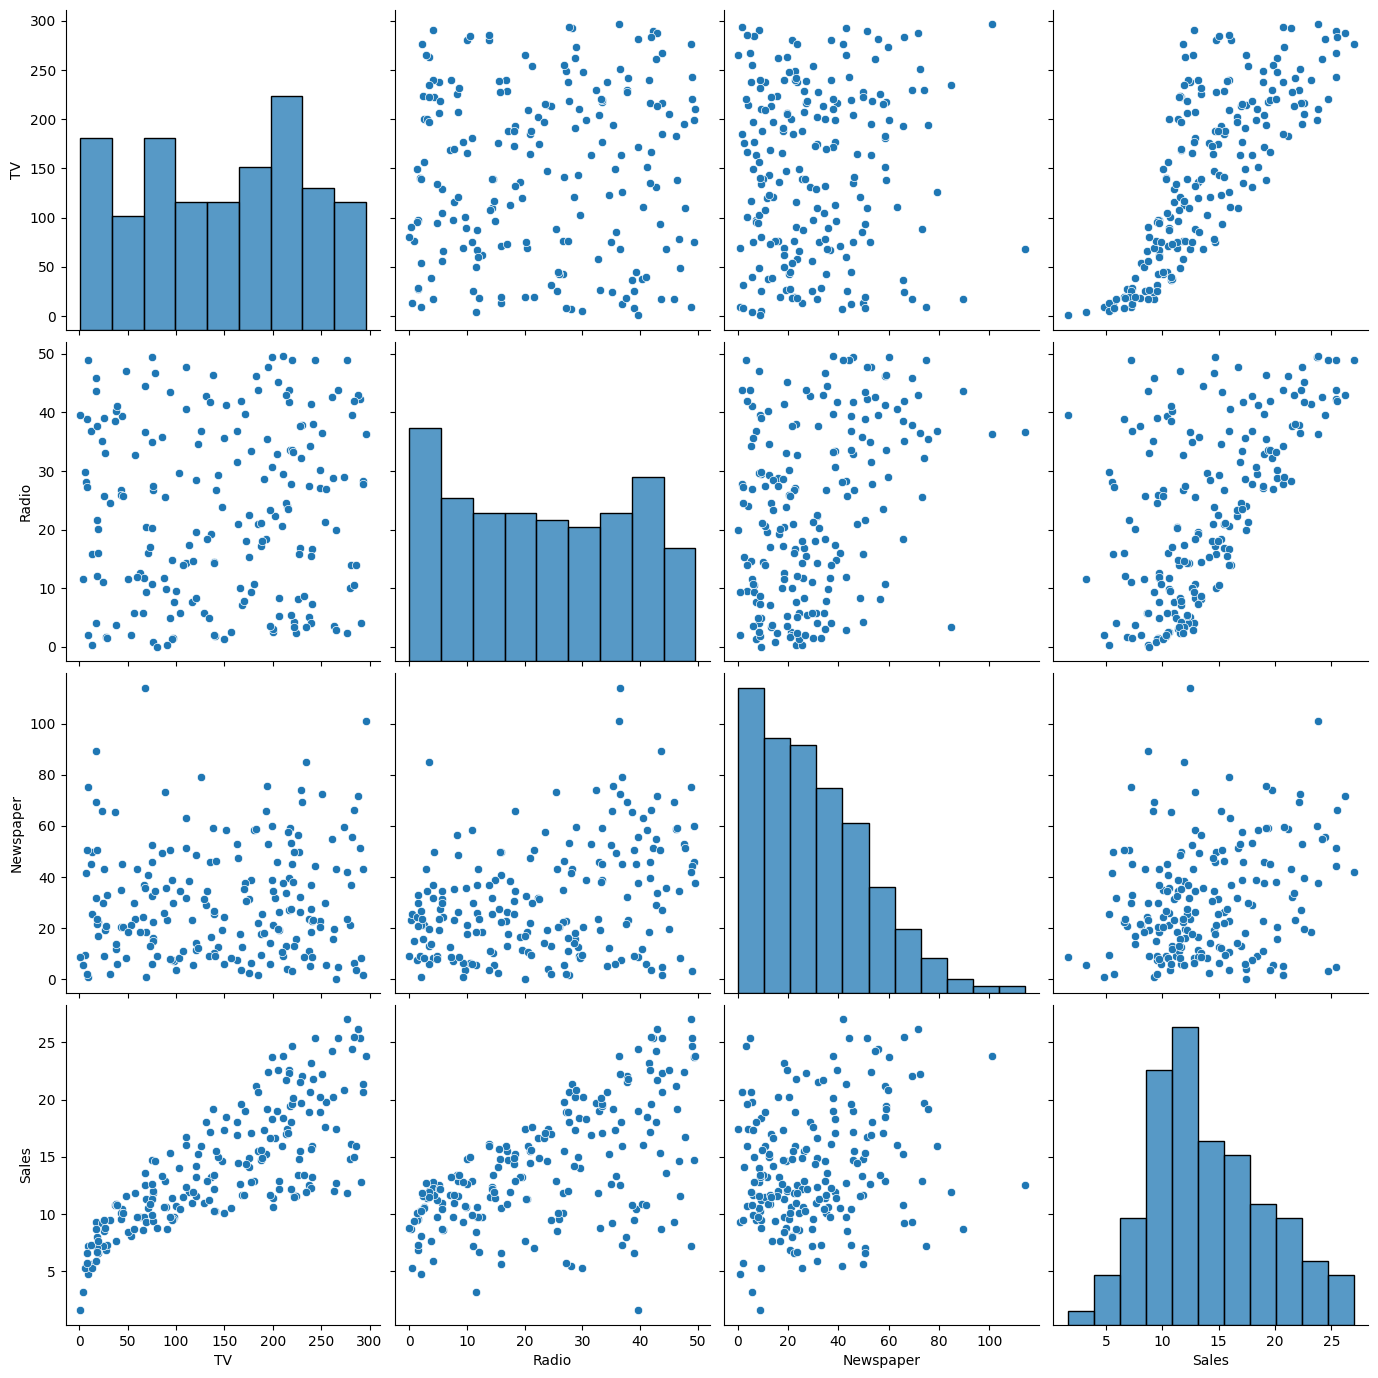

In [3]:
sns.pairplot(df, height=3.5)
print(df.describe().transpose())
plt.show()

## Training the Model — Estimating the Regression Coefficients

For the Multiple Linear Regression (MLR) model, we use the least squares method to estimate the regression coefficients — the same foundational approach as in simple linear regression. However, unlike simple regression, the estimation in MLR is carried out using matrix algebra.

The [complete derivation](../theory-docs/04-OLS-MLR.ipynb) can be found in the following notebook: `theory-docs/04-OLS-MLR.ipynb`

The final matrix formula for estimating the regression coefficients is:

$$
\boxed{
\hat\beta = (X^\top X)^{-1} X^\top y
}
$$

where:

- X is the matrix of input features (with a column of ones for the intercept),

- y is the response vector,

- $\hat\beta$ is the vector of estimated coefficients.

### Manual Calculation

In [4]:
# Step 1: Extract features and target
features = ['TV', 'Radio', 'Newspaper']
X = df[features].values
y = df['Sales'].values.reshape(-1, 1)

# Step 2: Add intercept term
n_samples = X.shape[0]
X_b = np.concatenate([np.ones((n_samples, 1)), X], axis=1)

# Step 3: Normal Equation
XtX = np.dot(X_b.T, X_b)
XtX_inv = np.linalg.inv(XtX)
Xty = np.dot(X_b.T, y)
beta_hat = np.dot(XtX_inv, Xty)

# Step 4: Format as DataFrame
coef_names = ['Intercept'] + features
coef_df = pd.DataFrame(beta_hat, index=coef_names, columns=['Coefficient'])
print("Manual Computation — Coefficients:")
display(coef_df.round(4))

Manual Computation — Coefficients:


,Coefficient
Intercept,2.9389
TV,0.0458
Radio,0.1885
Newspaper,-0.0010


### Calculate with Scikit-Learn

In [5]:
# Step 1: Extract features and target
features = ['TV', 'Radio', 'Newspaper']
X = df[features].values
y = df['Sales'].values.reshape(-1, 1)

# Step 2: Fit model
model = LinearRegression()
model.fit(X, y)

# Step 3: Store and format results as DataFrame
beta_sklearn = np.concatenate([[model.intercept_[0]], model.coef_.flatten()])
coef_names = ['Intercept'] + features
coef_df = pd.DataFrame(beta_sklearn, index=coef_names, columns=['Coefficient'])

print("Scikit-Learn Estimation — Coefficients:")
display(coef_df.round(4))

Scikit-Learn Estimation — Coefficients:


,Coefficient
Intercept,2.9389
TV,0.0458
Radio,0.1885
Newspaper,-0.0010


## Separate Simple Linear Model v.s. Multiple Linear Model

In our previous Simple Linear Regression case study, we examined the relationship between a single predictor (TV spending) and the response (sales). Extending this by fitting separate simple regressions for each advertising medium (TV, Radio, Newspaper) introduces two major drawbacks:

1. **Lack of a unified prediction**  
   Each medium yields its own regression equation, making it unclear how to combine them into a single sales forecast when budgets for all three channels are available.

2. **Omitted-variable bias**  
   Estimating each coefficient in isolation ignores the influence of the other two media, potentially producing misleading estimates of each medium’s true effect on sales.

### Separate Simple Linear Regression Summary

| Feature    | Intercept |  Slope  | SE(Slope) |  t-stat  | p-value |
|------------|-----------|---------|-----------|----------|---------|
| **TV**     |    7.0326 |  0.0475 |    0.0027 |  17.6676 |  0.0000 |
| **Radio**  |    9.3116 |  0.2025 |    0.0204 |   9.9208 |  0.0000 |
| **Newspaper** | 12.3514 |  0.0547 |    0.0166 |   3.2996 |  0.0011 |

- All three media budgets show a statistically significant positive slope when modeled alone.  

- Radio has the largest univariate effect on sales (slope ≈ 0.20), followed by Newspaper (≈ 0.055) and TV (≈ 0.047).  

- However, these individually-fitted slopes ignore potential overlaps between ad channels.

In [6]:
from sklearn.linear_model import LinearRegression
from scipy.stats import t
import pandas as pd
import numpy as np

# List of features to model separately
features = ['TV', 'Radio', 'Newspaper']
results = []

for feature in features:
    X = df[[feature]].values
    y = df['Sales'].values.reshape(-1, 1)
    n = len(y)

    model = LinearRegression()
    model.fit(X, y)

    intercept = model.intercept_[0]
    slope = model.coef_[0][0]
    y_pred = model.predict(X)

    # Residuals and RSS
    residuals = y - y_pred
    RSS = np.sum(residuals ** 2)

    # Standard error of slope
    x_diff_sq_sum = np.sum((X - np.mean(X)) ** 2)
    RSE = np.sqrt(RSS / (n - 2))  # residual standard error
    SE_slope = RSE / np.sqrt(x_diff_sq_sum)

    # t-statistic and p-value
    t_stat = slope / SE_slope
    p_val = 2 * (1 - t.cdf(np.abs(t_stat), df=n - 2))

    results.append({
        'Feature': feature,
        'Intercept': intercept,
        'Slope': slope,
        'SE(Slope)': SE_slope,
        't-stat': t_stat,
        'p-value': p_val
    })

# Format and display
simple_lm_df = pd.DataFrame(results)
print("Simple Linear Regression Summary:")
display(simple_lm_df.round(4))

Simple Linear Regression Summary:


,Feature,Intercept,Slope,SE(Slope),t-stat,p-value
0,TV,7.0326,0.0475,0.0027,17.6676,0.0000
1,Radio,9.3116,0.2025,0.0204,9.9208,0.0000
2,Newspaper,12.3514,0.0547,0.0166,3.2996,0.0011


### Multiple Linear Regression Summary

| Coefficient |  Value   |
|-------------|----------|
| **Intercept**   |  2.9389 |
| **TV**          |  0.0458 |
| **Radio**       |  0.1885 |
| **Newspaper**   | –0.0010 |

- Controlling for the other two media, **TV** remains a strong positive predictor (≈ 0.046 additional sales per unit spend).  

- **Radio** also retains a positive effect (≈ 0.189), slightly reduced from its univariate slope.  

- **Newspaper** turns slightly negative (≈ –0.001) and is effectively negligible—suggesting no unique contribution once TV and Radio are accounted for.  

- The drop (and sign-flip) in Newspaper’s coefficient highlights the omitted-variable bias present in the separate simple regressions.  

### Question

Does it make sense for the multiple regression to suggest no relationship between **sales** and **newpaper** while the simple linear regression implies the opposite? In fact it does. The reason will be discussed in the next section - Correlation matrix

### Correlation Matrix: Why we don't prefer Separate Linear Model

- The correlation between **Radio** and **Newspaper** is **0.35**, indicating that markets with high newspaper spending also tend to allocate more to radio.  

- In a Simple Linear Regression (SLR), newspaper spend appears positively associated with sales. However, in a Multiple Linear Regression (MLR) that controls for all three media, newspaper is no longer significant.  

- Instead, **Radio** remains a strong predictor of sales. Because radio and newspaper budgets are correlated, newspaper spending acts as a **surrogate** for radio in the SLR model—“taking credit” for radio’s true effect on sales.  

- This counterintuitive pattern is common in real-world data. For example, a simple regression of shark attacks on ice-cream sales at a beach would show a positive relationship—yet banning ice cream wouldn’t reduce attacks. In reality, warmer temperatures drive both more ice-cream purchases and more beach visits (hence more shark sightings). A multi-variable regression including temperature reveals that ice-cream sales lose significance once weather is accounted for.  

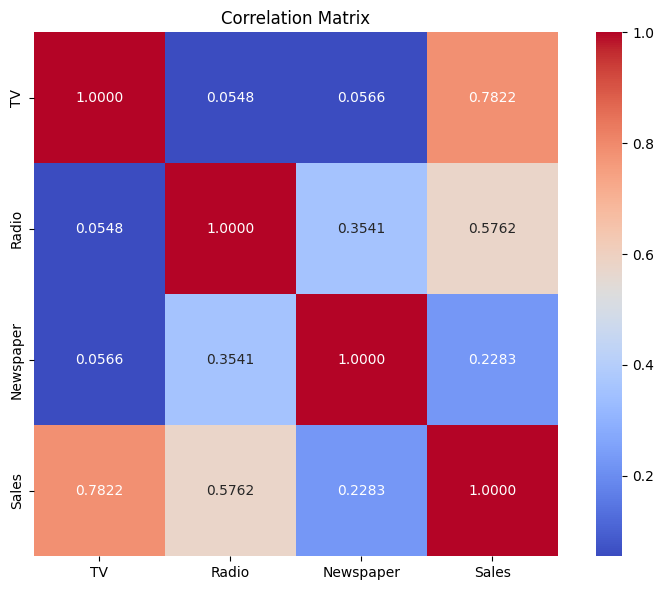

In [7]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Hypothesis Testing: Is There a Relationship Between the Response and Predictors?

### Test Statistic (F-statistic) for the Overall Model:

Goal: Test whether all predictors jointly have explanatory power on the response variable. (We normally do this step before evaluate individual coefficient)

$$
H_0: \beta_1 = \beta_2 = \dots = \beta_p = 0 \quad \text{(no predictor is useful)} \\
H_a: \text{At least one } \beta_j \ne 0
$$

Note:

[1] $\beta_0$(Intercept) is not 0

$$
F = \frac{(TSS - RSS) / p}{RSS / (n - p - 1)}
  = \frac{ \text{Explained variance} / p }{ \text{Unexplained variance} / (n - p - 1) } = \frac{MSR}{MSE}

$$

Where:
- $TSS = \sum_{i=1}^n (y_i - \bar{y})^2$
- $RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2$
- **MSR**: Mean Square Regression (explained variance)  
- **MSE**: Mean Square Error (unexplained variance)
- **p**: number of predictors
- **n**: number of observations
- $n - p - 1$: residual degrees of freedom

When there is **no relationship** between the response and predictors, F-statistic is expected **close to 1**. One the other hand, **if $H_a$ is true**, we expect F to be **greater than 1**. 

**Note:** F-statistic only tell you if at least one variable has relationship with response, but we don't know which variable(s).

> How to define F is large or not? it depends on case to case 
> 
> When n is large, F-statistic that is ust a lttle larger than 1 might still provide evidence against $H_0$ 
> 
> In contrast, a larger F-statistic is needed to reject $H_0$ if n is small 

---

### Why don't we use t-test or p-values to perform hypothesis testing?

If we use the individual t-statistics and associated p-values in order to decide whether or not there is any association between the variables and the response, there is a very hight change that we will incorrectly conclude that there is a relationship(p-value < 0.5). However, the F-statistic does not suffer from this problem because it adjusts for the number of predictors.

When you do multiple individual t-tests (one for each predictor), you’re doing multiple hypothesis tests. This creates a risk of false positives — that is, you might incorrectly find a significant result just by chance.

Imagine this:
- Suppose none of the predictors actually affect the response.
- But you’re testing 10 predictors.
- Even if each one has only a 5% chance (p < 0.05) of appearing significant by accident, testing 10 of them means your chance of finding at least one false positive is much higher than 5% — closer to 40%!
  - That’s $1 − 0.05 = 0.95$ (i.e., 95% chance of correctly not rejecting the null when it’s true).
  - Assume all 10 tests are independent. What’s the chance of no false positives in all 10 tests? $0.95^{10} \approx 0.5987$
  - Now, what’s the chance of at least one false positive? That’s 1 minus the chance of no false positives: $1 - 0.95^{10} \approx 1 - 0.5987 = 0.4013$

The F-test does not test predictors one by one. Instead, it asks a global question:

“Do any of the predictors, as a group, help explain the response?”

It compares:
- A model with all the predictors (full model)
- Versus a model with none of the predictors (intercept-only model)

Because it considers all predictors together, it adjusts for the number of predictors and helps control the overall error rate — reducing the chance of false positives due to multiple tests.

---

### Interpretation

**F-statistic**

The F-statistic is 570.3(code below). Since this is far larger than 1, it provides compelling evidence against the null hypothesis $H_0$. In other words, **the large F-statistic suggests that at least one of the advertising media must be related to sales**. 

---

In [8]:
# set X（predictors）and y（response）
X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

# add constant term for intercept
X = sm.add_constant(X)

# fit multiple linear regression model
model = sm.OLS(y, X).fit()

# Display full summary (includes std err, t, P>|t|, R², etc.)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 20 Jul 2025   Prob (F-statistic):           1.58e-96
Time:                        14:04:31   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

# Deciding on Important Variables

**You can see from the previous table, Newspaper’s p-value is 0.860, why not just remove it directly? Why do I need forward, backward, or mixed selection?”**

| Predictor    | Coefficient | t-value | p-value | Interpretation |
|--------------|-------------|---------|---------|----------------|
| **const**     | 2.9389      | 9.422   | < 0.001 | Intercept is significant; baseline Sales when all media spend = 0. |
| **TV**        | 0.0458      | 32.809  | < 0.001 | **Highly significant** positive effect on Sales. |
| **Radio**     | 0.1885      | 21.893  | < 0.001 | **Highly significant** positive effect on Sales. |
| **Newspaper** | -0.0010     | -0.177  | 0.860   | ❌ Not significant; no evidence Newspaper affects Sales.(We will have detail discuss in the this section - Deciding on Important Variables) |

**We use forward/backward/mixed selection because: The p-values can change depending on which variables are in the model. You cannot trust the p-values in one fixed model to tell the whole story.**

- After F-statistic, if we conclude at least one of the predictors is related to the response, it is natural to wonder which ones

- It is possible that all of the predictor are associated with the response, but it is more often the case that the response is only associated with a subset of the predictors.(As we have examined in the previous section)

- The task of determining which predictors are associated with the response, in order to fit a single model involving only those predictors, is referred to as **variable selection**.

- Testing all combination($2^{\text{p}}$ or $2^{\text{number of coefficients}}$) of models doesn't work because you have too many models to test. Therefore, there are three classical approaches for this task:
  
  - **Forward selection**: Forward selection is a stepwise modeling approach that starts with no predictors and adds one variable at a time—the one that leads to the greatest reduction in RSS—until no further meaningful improvement is made or a stopping criterion is met.
  
  - **backward selection**: Backward selection is a stepwise modeling approach that starts with all candidate predictors and removes one variable at a time—the one that contributes the least to the model (e.g., highest p-value or smallest impact on RSS)—until no further meaningful improvement can be achieved or a stopping criterion is met.
  
  - **mixed selection**: Mixed selection is a modeling method that starts with no variables, and at each step, it adds the variable with the smallest p-value (if it’s below a threshold like 0.05), and also removes any variable already in the model if its p-value becomes too large or above the threshold(Because p-values can change when you add other variables to the model), repeating this process until no more variables can be added or removed.

> Backword selection cannot be used if p > n, which forward selection can always be used. Forward selection is a greedt approach, and might include variables early that later become redundant. Mixed selection can remedy this.

- The quality of model can be determined by:
  
  - Mallow's C
  
  - Akaike Information Criterion(AIC)
  
  - Bayesian information Criterion(BIC)
  
  - Adjusted R2

In [40]:
custom_order = ['Newspaper', 'Radio', 'TV']  # You control this

selected, model = forward_selection(df, response='Sales', candidate_order=custom_order)

print("\nFinal variable selection order:", selected)
print(model.summary())


Step 1 | Current model: []
   → Evaluating 'Newspaper': p-value = 0.0011 | RSS = 5134.8045
   → Evaluating 'Radio': p-value = 0.0000 | RSS = 3618.4795
   → Evaluating 'TV': p-value = 0.0000 | RSS = 2102.5306
Added: TV (p = 0.0000 < 0.05)

Step 2 | Current model: ['TV']
   → Evaluating 'Newspaper': p-value = 0.0000 | RSS = 1918.5618
   → Evaluating 'Radio': p-value = 0.0000 | RSS = 556.9140
Added: Radio (p = 0.0000 < 0.05)

Step 3 | Current model: ['TV', 'Radio']
   → Evaluating 'Newspaper': p-value = 0.8599 | RSS = 556.8253
No variable meets the significance threshold. Stopping.

Final variable selection order: ['TV', 'Radio']
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Sun, 20 Jul 2025   Prob (F-

In [41]:
selected, model = backward_selection(df, response='Sales')

print("\nFinal variables after backward selection:", selected)
print(model.summary())


Step 1 | Current model: ['TV', 'Radio', 'Newspaper']
P-values and RSS:
   - TV: p-value = 0.0000
   - Radio: p-value = 0.0000
   - Newspaper: p-value = 0.8599
   RSS = 556.8253
Removing 'Newspaper' (p = 0.8599 > 0.05)

Step 2 | Current model: ['TV', 'Radio']
P-values and RSS:
   - TV: p-value = 0.0000
   - Radio: p-value = 0.0000
   RSS = 556.9140
All variables have p-values below threshold. Stopping.

Final variables after backward selection: ['TV', 'Radio']
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Sun, 20 Jul 2025   Prob (F-statistic):           4.83e-98
Time:                        14:34:17   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                 

# Model Fit

- RSE and R2 are most important
- The previous table shows R2 of 0.8972 on the model that uses all three advertising media to predict sales.
- if you drop newspaper and calculate the model again, you will have R2 of 0.89719.
- it says even thought p-value(0.860) from preivous table indicates that newspaper is not significant and very weakly associated with the response, R2 will slightly increase when it is added into the model.
- In fact, adding newspaper  to the model leads to tiny increase in R2 provideds additional evidence that newspaper can be dropped from the model.
- If model only contain TV, we will have R2 of 0.61. Adding radio to the model leads to a substantial improvement in R2. This implies that a model that uses TV and radio expenditures to predict sales is substantially better than one that uses only TV advertising.
- We can further quantify this improvement by looking at p-value and R2 in a model that contains only TV and radio.
- Calculate RSE(Page97)

# Prediction

Confidence Interval(page99)

# Synergy/Interaction Effect

- The Linear model states that the average inscrease in sales associated with one-unit inscrease in TV is always Beta1, regardless of the amount spent on radio. However, this simple model may be incorrect.Given a fixed budget of $100,000, spending half on radio and half on TV may increase sales more than allocating the entire amount to either TV or to radio. So, we need to test the Synergy/Interaction effect.
- Formula(P104)